In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station

Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Firstly want to print both table column names
print(Station.__table__.columns.keys())
print(Measurement.__table__.columns.keys()) #We will be using this table for precipitation

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']
['id', 'station', 'date', 'prcp', 'tobs']


In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(recent_date)

2017-08-23


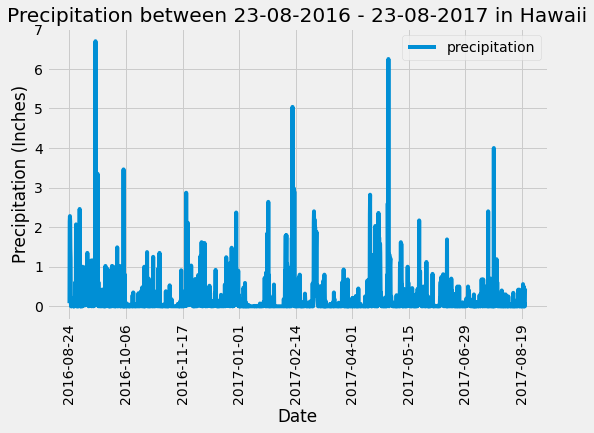

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. (2016-08-23 - 2017-08-23)

# Calculate the date one year from the last date in data set.
query_date = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# print(query_date)

# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= query_date).all()
# for row in precipitation:
#     print(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns = ['date','pcrp'])
precipitation_df.rename(columns = {'pcrp':'precipitation'}, inplace = True)
precipitation_df.set_index('date', inplace = True)

precipitation_df.head()

# # Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by ='date').dropna()
precipitation_df.head()


# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(rot = 90, figsize = (8,5),
                      title = "Precipitation between 23-08-2016 - 23-08-2017 in Hawaii")
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (Inches)')
plt.savefig('Images/precipitation.png', bbox_inches = "tight")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station).count()
print(f'There are {num_stations} stations in the dataset')

There are 9 stations in the dataset


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Most active station = 'USC00519281'
USC00519281_data = session.query(func.min(Measurement.tobs), 
                                        func.max(Measurement.tobs),
                                        func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()

print(USC00519281_data)

[(54.0, 85.0, 71.66378066378067)]


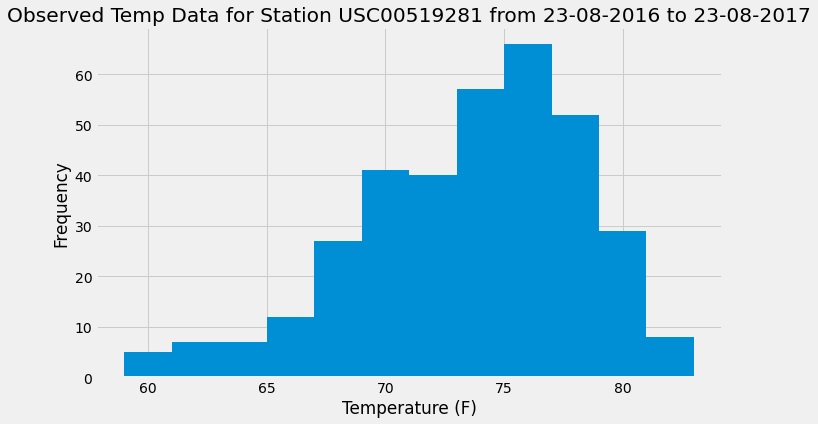

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_12mo = session.query(Measurement.tobs).\
                    filter(Measurement.station == "USC00519281").\
                    filter(Measurement.date >= query_date).all()
# print(USC00519281_12mo)

USC00519281_tobs = [result[0] for result in USC00519281_12mo]
# print(USC00519281_tobs)

plt.figure(figsize=(10,6))
plt.hist(USC00519281_tobs, bins = 12)
plt.title("Observed Temp Data for Station USC00519281 from 23-08-2016 to 23-08-2017")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.savefig('Images/USC00519281_tobs.png', bbox_inches = "tight")
plt.show()

# Close session

In [17]:
# Close Session
session.close()